In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

This was made using the `video_predictor_example.ipynb` available in the `notebooks` folder of the SAM2 model. Make sure to install the notebboks as their installation guide tells you.

# Video segmentation with SAM 2

This notebook shows how to use SAM 2 for interactive segmentation in videos. It will cover the following:

- adding clicks (or box) on a frame to get and refine _masklets_ (spatio-temporal masks)
- propagating clicks (or box) to get _masklets_ throughout the video
- segmenting and tracking multiple objects at the same time

We use the terms _segment_ or _mask_ to refer to the model prediction for an object on a single frame, and _masklet_ to refer to the spatio-temporal masks across the entire video. 

<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/video_predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Environment Set-up

If running locally using jupyter, first install `sam2` in your environment using the [installation instructions](https://github.com/facebookresearch/sam2#installation) in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

In [2]:
using_colab = False

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p videos
    !wget -P videos https://dl.fbaipublicfiles.com/segment_anything_2/assets/bedroom.zip
    !unzip -d videos videos/bedroom.zip

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

## Set-up

In [6]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [8]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


### Loading the SAM 2 video predictor

In [11]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [12]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

#### Select an example video

We assume that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`.

For your custom videos, you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`.

In [4]:
!ffmpeg -i ./videos/fish4_6hpA_r.mp4 -q:v 2 -start_number 0 ./videos/macro/'%05d.jpg'

ffmpeg version 4.4.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 12.3.0 (conda-forge gcc 12.3.0-2)
  configuration: --prefix=/home/gbouland/micromamba/envs/sam-env --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1697113881276/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1697113881276/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1697113881276/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1697113881276/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-avresample --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-gnutls --enable-libmp3lame --enable-libvpx --enable-pthreads --enable-vaapi --enable-gpl --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-pic --enable-shar

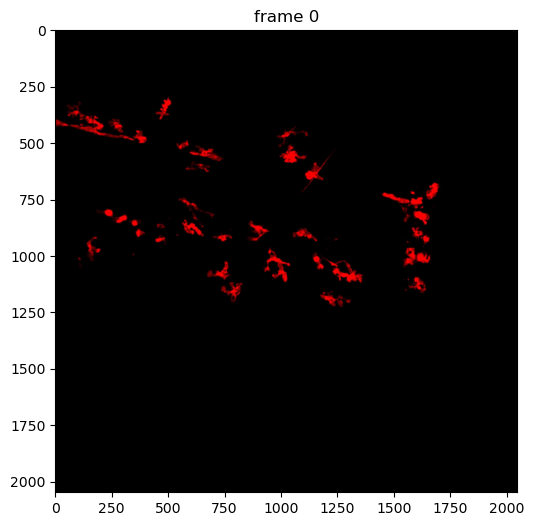

In [9]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "./videos/macro"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

## Tracking of 1 macrophage

#### Initialize the inference state

SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [15]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 130/130 [00:09<00:00, 13.65it/s]


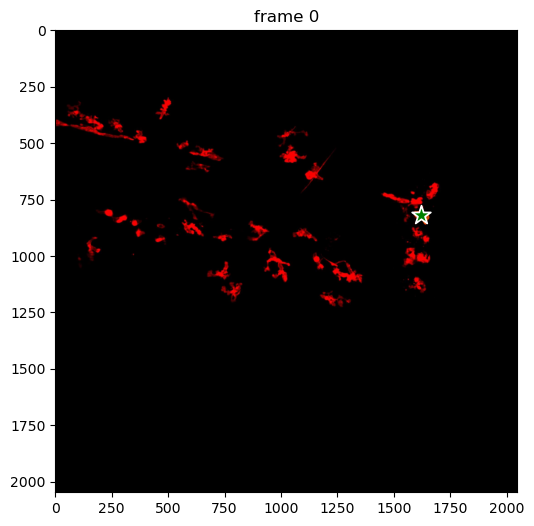

In [18]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[1620, 820]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

propagate in video: 100%|██████████| 130/130 [00:13<00:00,  9.80it/s]


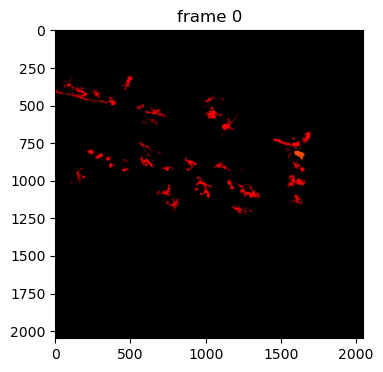

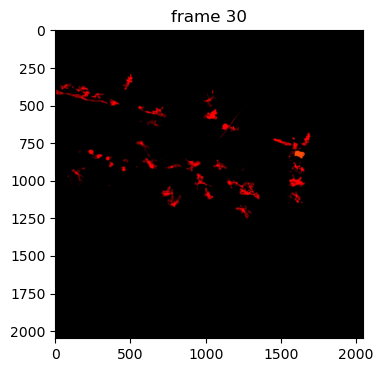

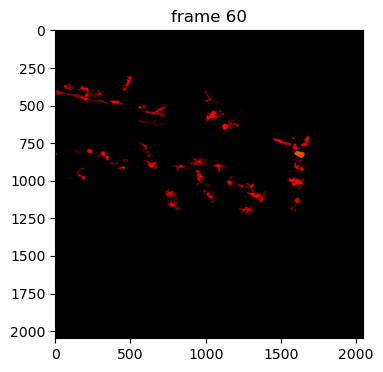

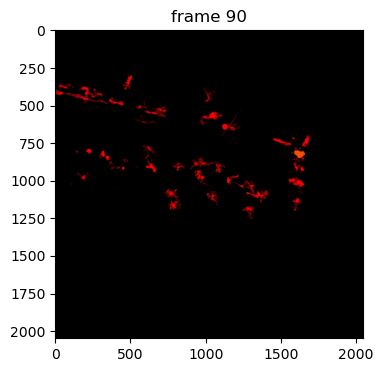

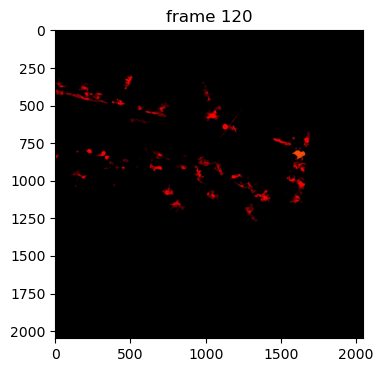

In [22]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [24]:
output_dir = "./videos/macro/output"
os.makedirs(output_dir, exist_ok=True)

for out_frame_idx in range(len(frame_names)):  # Parcourir toutes les frames
    # Charger l'image originale
    img_path = os.path.join(video_dir, frame_names[out_frame_idx])
    img = Image.open(img_path)

    # Créer la figure sans axes
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.imshow(img)
    ax.axis("off")  # Supprimer les axes

    # Appliquer les masques
    if out_frame_idx in video_segments:  # Vérifier si des masques existent pour cette frame
        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            show_mask(out_mask, ax, obj_id=out_obj_id)
    
    output_path = os.path.join(output_dir, f"frame_{out_frame_idx:05d}.png")
    plt.savefig(output_path, bbox_inches="tight", pad_inches=0)
    plt.close(fig)


In [ ]:
![ -f output_macro.mp4 ] && rm output_macro.mp4 # verify if the output_macro file already exists, if so, remove it
!ffmpeg -framerate 7 -i videos/macro/output/frame_%05d.png -c:v libx264 -pix_fmt yuv420p output_macro.mp4 # create a video from the frames
!mv output_macro.mp4 videos/macro/output/vid/ # move the video to the vid folder

ffmpeg version 4.4.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 12.3.0 (conda-forge gcc 12.3.0-2)
  configuration: --prefix=/home/gbouland/micromamba/envs/sam-env --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1697113881276/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1697113881276/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1697113881276/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1697113881276/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-avresample --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-gnutls --enable-libmp3lame --enable-libvpx --enable-pthreads --enable-vaapi --enable-gpl --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-pic --enable-shar

## Tracking of 2 macrophages

Here we will try to track two macrophages at the same time using different IDs for each one. The second macrophage we chose is quite special because it is in fact a cluster of macrophages. In the middle of the video, a macrophage detach itself from the cluster.  
We chose this one to test if SAM2 as it is is capable of adding new IDs when a new macrophages appear in the middle of the video without being initialized at the first frame.

In [78]:
predictor.reset_state(inference_state)

In [79]:
prompts={}

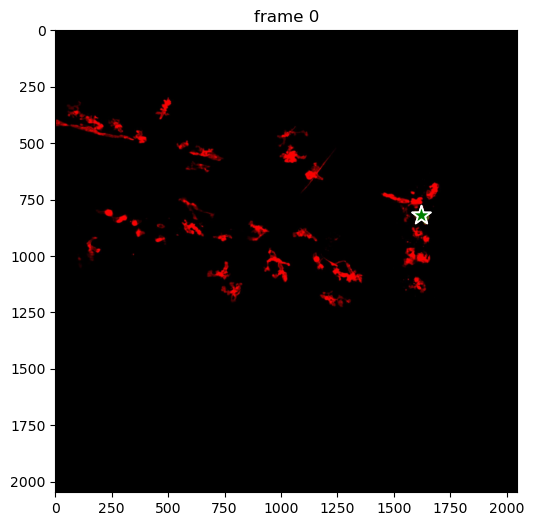

In [80]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 2  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (200, 300) to get started on the first object
points = np.array([[1620, 820]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
prompts[ann_obj_id] = points, labels
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

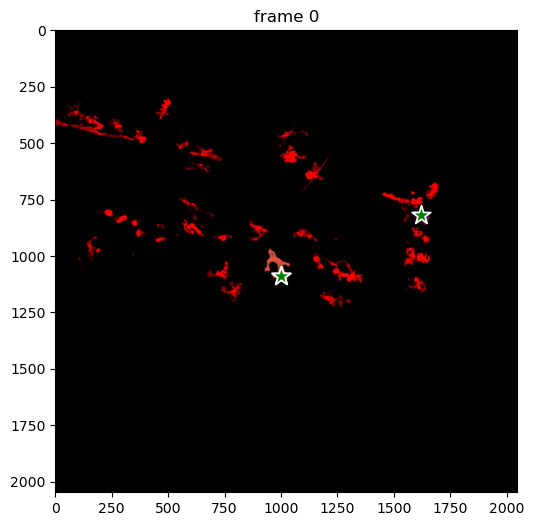

In [81]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 3  # give a unique id to each object we interact with (it can be any integers)

# Let's now move on to the second object we want to track (giving it object id `3`)
# with a positive click at (x, y) = (400, 150)
points = np.array([[1000, 1090]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
prompts[ann_obj_id] = points, labels

# `add_new_points_or_box` returns masks for all objects added so far on this interacted frame
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame on all objects
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id, random_color=True)

propagate in video:   0%|          | 0/130 [00:00<?, ?it/s]

propagate in video: 100%|██████████| 130/130 [00:14<00:00,  8.73it/s]


{0: {2: array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]]), 3: array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])}, 1: {2: array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, F

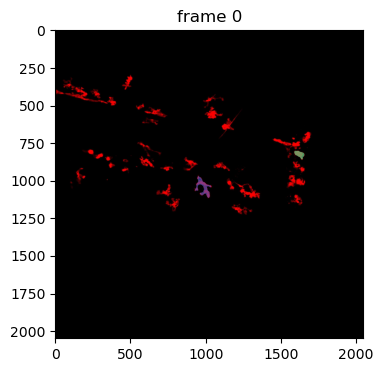

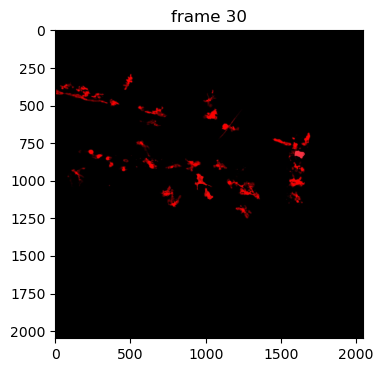

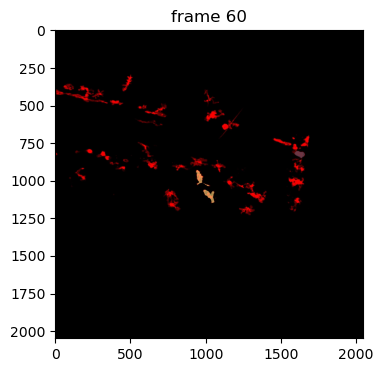

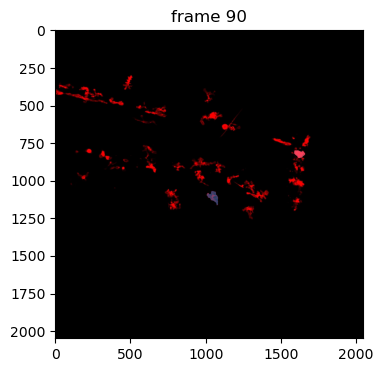

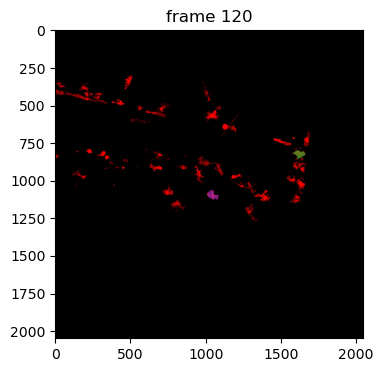

In [ ]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id, random_color=True)


In [ ]:
output_dir = "./videos/macro/output2"
os.makedirs(output_dir, exist_ok=True)

# render the segmentation results every few frames
vis_frame_stride = 1
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.imshow(img)
    ax.axis("off")  # Supprimer les axes
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id, random_color=True)
    plt.savefig(os.path.join(output_dir, f"frame_{out_frame_idx:05d}.png"), bbox_inches="tight", pad_inches=0)
    plt.close(fig)  

In [87]:
vid = "./videos/macro/output2/vid"
os.makedirs(vid, exist_ok=True)

In [ ]:
![ -f output2_macro.mp4 ] && rm output2_macro.mp4 # verify if the output2_macro file already exists, if so, remove it
!ffmpeg -framerate 7 -i videos/macro/output2/frame_%05d.png -vf scale=1280:720 -c:v libx264 -pix_fmt yuv420p output2_macro.mp4 # create a video from the frames
!mv output2_macro.mp4 videos/macro/output2/vid/ # move the video to the vid folder

ffmpeg version 4.4.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 12.3.0 (conda-forge gcc 12.3.0-2)
  configuration: --prefix=/home/gbouland/micromamba/envs/sam-env --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1697113881276/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1697113881276/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1697113881276/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1697113881276/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-avresample --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-gnutls --enable-libmp3lame --enable-libvpx --enable-pthreads --enable-vaapi --enable-gpl --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-pic --enable-shar

As we can see when the cluster splits, for a moment the two macrophage resulting form that event have the same ID and later on, one of the two is not tracked anymore.  
That shows a limit in the SAM2 algorithm and specifically in its usage in biomedical data segmentation.